In [1]:
################################################################################
#
# LOGISTICS
#
#    Kapil Gautam
#    KXG180032
#
# DESCRIPTION
#
#    Image classification in PyTorch for ImageNet reduced to 100 classes and
#    down sampled such that the short side is 64 pixels and the long side is
#    >= 64 pixels
#
#    This script achieved a best accuracy of ??.??% on epoch ?? with a learning
#    rate at that point of ?.????? and time required for each epoch of ~ ??? s
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Run all
#
# NOTES
#
#    0. For a mapping of category names to directory names see:
#       https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57
#
#    1. The original 2012 ImageNet images are down sampled such that their short
#       side is 64 pixels (the other side is >= 64 pixels) and only 100 of the
#       original 1000 classes are kept.
#
#    2. Build and train a RegNetX image classifier modified as follows:
#
#       - Set stride = 1 (instead of stride = 2) in the stem
#       - Replace the first stride = 2 down sampling building block in the
#         original network by a stride = 1 normal building block
#       - The fully connected layer in the decoder outputs 100 classes instead
#         of 1000 classes
#
#       The original RegNetX takes in 3x224x224 input images and generates Nx7x7
#       feature maps before the decoder, this modified RegNetX will take in
#       3x56x56 input images and generate Nx7x7 feature maps before the decoder.
#       For reference, an implementation of this network took ~ 112 s per epoch
#       for training, validation and checkpoint saving on Sep 27, 2020 using a
#       free GPU runtime in Google Colab.
#
################################################################################

In [2]:
################################################################################
#
# IMPORT
#
################################################################################

# torch
import torch
import torch.nn       as     nn
import torch.optim    as     optim
from   torch.autograd import Function

# torch utils
import torchvision
import torchvision.transforms as transforms

# additional libraries
import os
import urllib.request
import zipfile
import time
import math
import numpy             as np
import matplotlib.pyplot as plt

In [3]:
################################################################################
#
# PARAMETERS
#
################################################################################
torch.manual_seed(0)
np.random.seed(0)
# data
DATA_DIR_1        = 'data'
DATA_DIR_2        = 'data/imagenet64'
DATA_DIR_TRAIN    = 'data/imagenet64/train'
DATA_DIR_TEST     = 'data/imagenet64/val'
DATA_FILE_TRAIN_1 = 'Train1.zip'
DATA_FILE_TRAIN_2 = 'Train2.zip'
DATA_FILE_TRAIN_3 = 'Train3.zip'
DATA_FILE_TRAIN_4 = 'Train4.zip'
DATA_FILE_TRAIN_5 = 'Train5.zip'
DATA_FILE_TEST_1  = 'Val1.zip'
DATA_URL_TRAIN_1  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train1.zip'
DATA_URL_TRAIN_2  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train2.zip'
DATA_URL_TRAIN_3  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train3.zip'
DATA_URL_TRAIN_4  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train4.zip'
DATA_URL_TRAIN_5  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train5.zip'
DATA_URL_TEST_1   = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Val1.zip'
DATA_BATCH_SIZE   = 512
# DATA_BATCH_SIZE   = 128
DATA_NUM_WORKERS  = 4
DATA_NUM_CHANNELS = 3
DATA_NUM_CLASSES  = 100
DATA_RESIZE       = 64
DATA_CROP         = 56
DATA_MEAN         = (0.485, 0.456, 0.406)
DATA_STD_DEV      = (0.229, 0.224, 0.225)

# model
# add model parameters here

# training
# add training parameters here

# file
# add file parameters here


In [71]:
#Class Code directory
# model
MODEL_LEVEL_0_BLOCKS            = 1
MODEL_LEVEL_1_BLOCKS            = 1
MODEL_LEVEL_2_BLOCKS            = 4
MODEL_LEVEL_3_BLOCKS            = 7
# MODEL_TAIL_END_CHANNELS         = 32
MODEL_TAIL_END_CHANNELS         = 24
MODEL_LEVEL_0_IDENTITY_CHANNELS = 24
MODEL_LEVEL_1_IDENTITY_CHANNELS = 56
MODEL_LEVEL_2_IDENTITY_CHANNELS = 152
MODEL_LEVEL_3_IDENTITY_CHANNELS = 368

# training (linear warm up with cosine decay learning rate)
TRAINING_LR_MAX          = 0.01
TRAINING_LR_INIT_SCALE   = 0.1
TRAINING_LR_INIT_EPOCHS = 5
TRAINING_LR_FINAL_SCALE = 0.3
TRAINING_LR_FINAL_EPOCHS = 25
# TRAINING_LR_FINAL_EPOCHS = 2 # uncomment for a quick test
TRAINING_NUM_EPOCHS      = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT         = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL        = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# file
FILE_NAME = 'RegNetX-200MF.pt'
FILE_SAVE = 0
FILE_LOAD = 0

In [5]:
################################################################################
#
# DATA
#
################################################################################

# create a local directory structure for data storage
if (os.path.exists(DATA_DIR_1) == False):
    os.mkdir(DATA_DIR_1)
if (os.path.exists(DATA_DIR_2) == False):
    os.mkdir(DATA_DIR_2)
if (os.path.exists(DATA_DIR_TRAIN) == False):
    os.mkdir(DATA_DIR_TRAIN)
if (os.path.exists(DATA_DIR_TEST) == False):
    os.mkdir(DATA_DIR_TEST)

# download data
if (os.path.exists(DATA_FILE_TRAIN_1) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_1, DATA_FILE_TRAIN_1)
if (os.path.exists(DATA_FILE_TRAIN_2) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_2, DATA_FILE_TRAIN_2)
if (os.path.exists(DATA_FILE_TRAIN_3) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_3, DATA_FILE_TRAIN_3)
if (os.path.exists(DATA_FILE_TRAIN_4) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_4, DATA_FILE_TRAIN_4)
if (os.path.exists(DATA_FILE_TRAIN_5) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_5, DATA_FILE_TRAIN_5)
if (os.path.exists(DATA_FILE_TEST_1) == False):
    urllib.request.urlretrieve(DATA_URL_TEST_1, DATA_FILE_TEST_1)

# extract data
with zipfile.ZipFile(DATA_FILE_TRAIN_1, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_2, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_3, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_4, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_5, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TEST_1, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TEST)

# transforms
transform_train = transforms.Compose([transforms.RandomResizedCrop(DATA_CROP),
                  transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])
transform_test  = transforms.Compose([transforms.Resize(DATA_RESIZE), transforms.CenterCrop(DATA_CROP),
                                      transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])

In [6]:
# data sets
dataset_train = torchvision.datasets.ImageFolder(DATA_DIR_TRAIN, transform=transform_train)
dataset_test  = torchvision.datasets.ImageFolder(DATA_DIR_TEST,  transform=transform_test)

In [7]:
# data loader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=DATA_BATCH_SIZE, shuffle=True,
                                               num_workers=DATA_NUM_WORKERS, pin_memory=True, drop_last=True)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=DATA_BATCH_SIZE, shuffle=False,
                                               num_workers=DATA_NUM_WORKERS, pin_memory=True, drop_last=True)

In [72]:
################################################################################
#
# NETWORK BUILDING BLOCK
#
################################################################################
# X block
class XBlock(nn.Module):

    # def __init__(self, C_in, C_res, C_out, S):
    # initialization
    def __init__(self, Ni, No, res_channel, Fr=3, Fc=3, Sr=2, Sc=2, G=8):

        # parent initialization
        super(XBlock, self).__init__()

        # add your code here
        # operations needed to create a parameterized XBlock
        C_res = res_channel
        num_groups = G
        # print("Ni {0}, No {1}, res_channel {2}, num_Groups {3}".format(Ni, No, res_channel, num_groups))
        # identity
        if ((Ni != No) or (Sr > 1)):
            self.conv0_present = True
            self.bn0          = nn.BatchNorm2d(Ni, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv0         = nn.Conv2d(Ni, No, (1, 1), stride=(Sr, Sc), padding=(0, 0), dilation=(1, 1),
                                           groups=num_groups, bias=False, padding_mode='zeros')
        else:
            self.conv0_present = False

        # residual
        self.bn1   = nn.BatchNorm2d(Ni, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(Ni, C_res, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1),
                               bias=False, padding_mode='zeros')
        self.bn2   = nn.BatchNorm2d(C_res, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(C_res, C_res, (3, 3), stride=(Sr, Sc), padding=(1, 1), dilation=(1, 1),
                               groups=num_groups, bias=False, padding_mode='zeros')
        self.bn3   = nn.BatchNorm2d(C_res, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu3 = nn.ReLU()
        self.conv3 = nn.Conv2d(C_res, No, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1),
                               bias=False, padding_mode='zeros')

    # forward path
    def forward(self, x):

        # add your code here
        # tie together the operations to create a parameterized XBlock
        # residual
        res = self.bn1(x)
        res = self.relu1(res)
        res = self.conv1(res)
        res = self.bn2(res)
        res = self.relu2(res)
        res = self.conv2(res)
        res = self.bn3(res)
        res = self.relu3(res)
        res = self.conv3(res)

        # identity
        if (self.conv0_present == True):
          x = self.bn0(x)
          x = self.conv0(x)

        # summation
        x = res + x

        # return
        return x


In [73]:
################################################################################
#
# NETWORK
#
################################################################################
# define
class Model(nn.Module):

    # initialization
    def __init__(self, data_num_channels, data_num_classes, model_level_0_blocks, model_level_1_blocks,
                 model_level_2_blocks, model_level_3_blocks, model_tail_end_channels, model_level_0_identity_channels, 
                 model_level_1_identity_channels, model_level_2_identity_channels, model_level_3_identity_channels):

        # parent initialization
        super(Model, self).__init__()

        # add your code here
        # operations needed to create a modified RegNetX-200MF network
        # use the parameterized XBlock defined to simplify this section

        # encoder tail
        self.enc_tail = nn.ModuleList()
        self.enc_tail.append(nn.BatchNorm2d(data_num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.enc_tail.append(nn.Conv2d(data_num_channels, model_tail_end_channels, (3, 3), stride=(1, 1),
                                       padding=(1, 1), dilation=(1, 1), bias=False, padding_mode='zeros'))

        # encoder level 0 - depth 1
        self.enc_0 = nn.ModuleList()
        self.enc_0.append(XBlock(model_tail_end_channels, model_level_0_identity_channels, 
                                 model_tail_end_channels, Fr=3, Fc=3, Sr=1,Sc=1))
        

        # encoder level 1 - depth 1
        self.enc_1 = nn.ModuleList()
        self.enc_1.append(XBlock(model_level_0_identity_channels, model_level_1_identity_channels,
                                 model_level_0_identity_channels, 2))
        

        # encoder level 2 - depth 4
        self.enc_2 = nn.ModuleList()
        self.enc_2.append(XBlock(model_level_1_identity_channels, model_level_2_identity_channels, model_level_1_identity_channels, 2))
        for n in range(model_level_2_blocks - 1):
            self.enc_2.append(XBlock(model_level_2_identity_channels, model_level_2_identity_channels, model_level_2_identity_channels, Fr=3, Fc=3, Sr=1,Sc=1))
        self.enc_2 = nn.Sequential(*self.enc_2)

        # encoder level 3 - depth 7
        self.enc_3 = nn.ModuleList()
        self.enc_3.append(XBlock(model_level_2_identity_channels, model_level_3_identity_channels, model_level_2_identity_channels, 2))
        for n in range(model_level_3_blocks - 1):
            self.enc_3.append(XBlock(model_level_3_identity_channels, model_level_3_identity_channels, model_level_3_identity_channels, Fr=3, Fc=3, Sr=1,Sc=1))

        # encoder level 3 complete the (conv) - bn - relu pattern
        self.enc_3.append(nn.BatchNorm2d(model_level_3_identity_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.enc_3.append(nn.ReLU())
        self.enc_3 = nn.Sequential(*self.enc_3)

        # decoder
        self.dec = nn.ModuleList()
        self.dec.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.dec.append(nn.Flatten())
        self.dec.append(nn.Linear(model_level_3_identity_channels, data_num_classes, bias=True))

    # forward path
    def forward(self, x):

        # add your code here
        # tie together the operations to create a modified RegNetX-200MF
        # encoder tail
        for layer in self.enc_tail:
            x = layer(x)

        # print("shape,tail",x.shape)
        # encoder level 0
        for layer in self.enc_0:
            x = layer(x)
        # print("shape,enc_0",x.shape)
        # encoder level 1
        for layer in self.enc_1:
            x = layer(x)
        # print("shape,enc_1",x.shape)
        # encoder level 2
        for layer in self.enc_2:
            x = layer(x)
        # print("shape,enc_2",x.shape)
        # encoder level 3
        for layer in self.enc_3:
            x = layer(x)
        # print("shape,enc_3",x.shape)
        # decoder
        for layer in self.dec:
            x = layer(x)
        # print("shape,decoder",x.shape)
        # return
        return x

In [74]:
# create
model = Model(DATA_NUM_CHANNELS, DATA_NUM_CLASSES, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS,
              MODEL_LEVEL_3_BLOCKS, MODEL_TAIL_END_CHANNELS, MODEL_LEVEL_0_IDENTITY_CHANNELS, 
              MODEL_LEVEL_1_IDENTITY_CHANNELS, MODEL_LEVEL_2_IDENTITY_CHANNELS,
              MODEL_LEVEL_3_IDENTITY_CHANNELS)

# visualization
print(model)

Model(
  (enc_tail): ModuleList(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (enc_0): ModuleList(
    (0): XBlock(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
      (conv3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (enc_1): ModuleList(
    (0): XBlock(
      (bn0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [75]:
# specify the device as the GPU if present with fallback to the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [76]:
# enable data parallelization for multi GPU systems
if (torch.cuda.device_count() > 1):
    model = nn.DataParallel(model)
print('Using {0:d} GPU(s)'.format(torch.cuda.device_count()), flush=True)

################################################################################
#
# ERROR AND OPTIMIZER
#
################################################################################

# add your code here
# define the error criteria and optimizer
# start epoch
start_epoch = 0

# learning rate schedule
def lr_schedule(epoch):

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, 
              math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    return lr

# error (softmax cross entropy)
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = optim.Adam(model.parameters(), lr=TRAINING_LR_INIT, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00005, amsgrad=False)
optimizer = optim.Adam(model.parameters(), lr=TRAINING_LR_INIT, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# transfer the network to the device
model.to(device)

# model loading
if FILE_LOAD == 1:
    checkpoint = torch.load(FILE_NAME)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

Using 1 GPU(s)


In [77]:
import time
train_start_time = time.time()

In [ ]:
################################################################################
#
# TRAINING
#
################################################################################
# add your code here
# perform network training, validation and checkpoint saving
# cycle through the epochs
for epoch in range(start_epoch, TRAINING_NUM_EPOCHS):

    epoch_start_time = time.time()
    # initialize train set statistics
    model.train()
    training_loss = 0.0
    num_batches   = 0

    # set the learning rate for the epoch
    for g in optimizer.param_groups:
        g['lr'] = lr_schedule(epoch)

    # cycle through the train set
    for data in dataloader_train:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass, loss, backward pass and weight update
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update statistics
        training_loss = training_loss + loss.item()
        num_batches   = num_batches + 1

    # initialize test set statistics
    model.eval()
    test_correct = 0
    test_total   = 0

    # no weight update / no gradient needed
    with torch.no_grad():

        # cycle through the test set
        for data in dataloader_test:

            # extract a batch of data and move it to the appropriate device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass and prediction
            outputs      = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # update test set statistics
            test_total   = test_total + labels.size(0)
            test_correct = test_correct + (predicted == labels).sum().item()

    epoch_end_time = time.time()
    # epoch statistics
    print('Epoch {0:2d} time {1:4.3f} lr = {2:8.6f} avg loss = {3:8.6f} accuracy = {4:5.2f}'.format(epoch,
          epoch_end_time - epoch_start_time, lr_schedule(epoch), (training_loss/num_batches)/DATA_BATCH_SIZE,
          (100.0*test_correct/test_total)))


Epoch  0 time 92.568 lr = 0.001000 avg loss = 0.006977 accuracy = 22.29
Epoch  1 time 92.693 lr = 0.002800 avg loss = 0.005949 accuracy = 27.76


In [15]:
train_end_time = time.time()
print("Total time taken = ", train_end_time - train_start_time)

Total time taken =  1873.2401297092438


In [16]:
# model saving
# to use this for checkpointing put this code block inside the training loop at the end (e.g., just indent it 4 spaces)
# and set 'epoch' to the current epoch instead of TRAINING_NUM_EPOCHS - 1; then if there's a crash it will be possible
# to load this checkpoint and restart training from the last complete epoch instead of having to start training at the
# beginning
if FILE_SAVE == 1:
    torch.save({
        'epoch': TRAINING_NUM_EPOCHS - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, FILE_NAME)

In [17]:
################################################################################
#
# TEST
#
################################################################################

# initialize test set statistics
model.eval()
test_correct = 0
test_total   = 0

# initialize class statistics
class_correct = list(0. for i in range(DATA_NUM_CLASSES))
class_total   = list(0. for i in range(DATA_NUM_CLASSES))

# no weight update / no gradient needed
with torch.no_grad():

    # cycle through the test set
    for data in dataloader_test:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass and prediction
        outputs      = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # update test set statistics
        test_total   = test_total + labels.size(0)
        test_correct = test_correct + (predicted == labels).sum().item()

        # update class statistics
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label                 = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

# test set statistics
print('Accuracy of test set = {0:5.2f}'.format((100.0*test_correct/test_total)))
print('')

Accuracy of test set = 63.00



In [18]:
################################################################################
#
# DISPLAY
#
################################################################################

# set to evaluation mode
model.eval()

# extract a batch of data
data_iterator  = iter(dataloader_test)
inputs, labels = data_iterator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: ignored

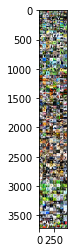

In [19]:
 # images and ground truth labels
images    = torchvision.utils.make_grid(inputs)/2 + 0.5
np_images = images.numpy()
plt.imshow(np.transpose(np_images, (1, 2, 0)))
print('Ground truth = ', ' '.join('%5s' % DATA_CLASS_NAMES[labels[j]] for j in range(DATA_BATCH_SIZE)))

# move it to the appropriate device
inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
# forward pass and prediction
outputs      = model(inputs)
_, predicted = torch.max(outputs, 1)

# predicted labels
print('Predicted    = ', ' '.join('%5s' % DATA_CLASS_NAMES[predicted[j]] for j in range(DATA_BATCH_SIZE)))
print('')